In [7]:
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from torchdiffeq import odeint
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [8]:

import random
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything()


In [9]:

class Encoder(nn.Module):
    def __init__(self, latent_dim=32):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

    def forward(self, x):
        h = self.fc(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z, mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28*28),
            nn.Sigmoid()
        )

    def forward(self, z):
        x_recon = self.net(z)
        return x_recon.view(-1, 1, 28, 28)


In [10]:

transform = transforms.ToTensor()
mnist_train = datasets.MNIST(root="./data", train=True, transform=transform, download=False)
mnist_loader = DataLoader(mnist_train, batch_size=128, shuffle=True)


In [11]:

def train_vae(encoder, decoder, dataloader, epochs=10, lr=1e-3):
    encoder.to(device)
    decoder.to(device)
    optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=lr)

    for epoch in range(epochs):
        total_loss = 0
        for x, _ in dataloader:
            x = x.to(device)
            z, mu, logvar = encoder(x)
            x_recon = decoder(z)

            recon_loss = nn.functional.binary_cross_entropy(x_recon, x, reduction='sum')
            kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            loss = recon_loss + kl_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if epoch % 10 == 0:
            print(f"Epoch {epoch} | VAE Loss: {total_loss / len(dataloader.dataset):.4f}")


In [12]:

encoder = Encoder(latent_dim=32)
decoder = Decoder(latent_dim=32)
train_vae(encoder, decoder, mnist_loader, epochs=30)


Epoch 0 | VAE Loss: 176.5833
Epoch 10 | VAE Loss: 102.7064
Epoch 20 | VAE Loss: 99.4089


In [13]:

all_z = []
with torch.no_grad():
    for x, _ in mnist_loader:
        x = x.to(device)
        z, _, _ = encoder(x)
        all_z.append(z)
latent_data = torch.cat(all_z, dim=0)
print("Latent data shape:", latent_data.shape)


Latent data shape: torch.Size([60000, 32])


In [14]:
class CNFNet(nn.Module):
    def __init__(self, input_dim=32, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim + 1, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, t, x):
        t_expand = t.expand_as(x[:, :1])
        xt = torch.cat([x, t_expand], dim=1)
        return self.net(xt)

def standard_normal_logprob(z):
    return -0.5 * (z.pow(2) + np.log(2 * np.pi)).sum(dim=1)

def trace_df_dx(f, x, t):
    e = torch.randn_like(x)
    e_dz = torch.autograd.grad(f(t, x), x, e, create_graph=True)[0]
    return (e_dz * e).sum(dim=1)

def train_cnf(model, data, epochs=50, batch_size=256, lr=1e-3, method="rk4"):
    device = next(model.parameters()).device
    data = data.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()

    for epoch in range(epochs):
        perm = torch.randperm(data.shape[0], device=device)
        for i in range(0, data.shape[0], batch_size):
            idx = perm[i:i + batch_size]
            x_T = data[idx].clone().detach().requires_grad_(True)
            logp_T = torch.zeros(x_T.shape[0], device=device)

            def odefunc(t, state):
                x, logp = state
                dx = model(t, x)
                dlogp = -trace_df_dx(model, x, t)
                return dx, dlogp

            t_vals = torch.tensor([1.0, 0.0], device=device)
            (z_0, delta_logp) = odeint(odefunc, (x_T, logp_T), t_vals, method=method,
                                        atol=1e-5, rtol=1e-5)
            logp_0 = standard_normal_logprob(z_0[-1])
            logp_x = logp_0 - delta_logp[-1]
            loss = -logp_x.mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if epoch % 10 == 0:
            print(f"[CNF] Epoch {epoch} | NLL: {loss.item():.4f}")


In [15]:
def sample_from_cnf_and_decode(cnf_model, decoder, n_samples=64):
    cnf_model.eval()
    decoder.eval()
    with torch.no_grad():
        z0 = torch.randn(n_samples, 32).to(device)

        def odefunc(t, x):
            return cnf_model(t, x)

        t_vals = torch.tensor([0.0, 1.0], device=device)
        z_T = odeint(odefunc, z0, t_vals)[-1]

        recon = decoder(z_T).cpu()
        return recon

def show_images_CNF(images, nrow=8, save_path = "generated_samples.png"):
    images = images.view(-1, 1, 28, 28)
    grid = torchvision.utils.make_grid(images, nrow=nrow)
    plt.figure(figsize=(8, 8))
    plt.imshow(grid.permute(1, 2, 0).squeeze())
    plt.axis("off")
    plt.title("Generated Images from CNF + Decoder")
    plt.savefig(save_path, dpi=300)
    print(f"Image saved to {save_path}")
    plt.show()   

In [16]:
class RFStudent(nn.Module):
    def __init__(self, dim=32, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 1, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, dim)
        )

    def forward(self, t, x):
        if len(t.shape) == 0:
            t = t.expand(x.shape[0], 1)
        elif len(t.shape) == 1:
            t = t.unsqueeze(1)
        tx = torch.cat([x, t], dim=1)
        return self.net(tx)
def train_rf_student(cnf_model, source_data, epochs=50, batch_size=256, num_steps=20, lr=1e-3):
    device = next(cnf_model.parameters()).device
    cnf_model.eval()
    student = RFStudent(dim=source_data.shape[1]).to(device)

    # Construct the trajectory from the teacher model
    t_vals = torch.linspace(0.0, 1.0, num_steps).to(device)
    z0 = source_data.to(device)

    with torch.no_grad():
        trajectory = odeint(cnf_model, z0, t_vals, method="rk4")

    t_samples, x_samples, v_samples = [], [], []

    for i in range(num_steps):
        t_i = t_vals[i]
        x_i = trajectory[i]
        with torch.no_grad():
            v_i = cnf_model(t_i, x_i)

        t_samples.append(t_i.expand(x_i.shape[0]))
        x_samples.append(x_i)
        v_samples.append(v_i)

    t_train = torch.cat(t_samples, dim=0)
    x_train = torch.cat(x_samples, dim=0)
    v_train = torch.cat(v_samples, dim=0)

    dataset = TensorDataset(t_train, x_train, v_train)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    optimizer = torch.optim.Adam(student.parameters(), lr=lr)
    for epoch in range(epochs):
        for t_b, x_b, v_b in loader:
            t_b, x_b, v_b = t_b.to(device), x_b.to(device), v_b.to(device)
            pred_v = student(t_b, x_b)
            loss = ((pred_v - v_b) ** 2).mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if epoch % 10 == 0:
            print(f"[RF] Epoch {epoch} | Loss: {loss.item():.4f}")

    return student

def sample_from_rf_and_decode(rf_model, decoder, n_samples=64, num_steps=20):
    device = next(rf_model.parameters()).device
    rf_model.eval()
    decoder.eval()

    with torch.no_grad():
        z = torch.randn(n_samples, 32).to(device)
        dt = 1.0 / num_steps
        t = torch.zeros(n_samples, 1).to(device)

        for _ in range(num_steps):
            v = rf_model(t.squeeze(1), z)
            z = z + dt * v
            t += dt

        recon = decoder(z).cpu()
        return recon

def show_images_RF(images, nrow=8, save_path = "generated_samples.png"):
    images = images.view(-1, 1, 28, 28)
    grid = torchvision.utils.make_grid(images, nrow=nrow)
    plt.figure(figsize=(8, 8))
    plt.imshow(grid.permute(1, 2, 0).squeeze())
    plt.axis("off")
    plt.title("Generated Images from CNF + Decoder")
    plt.savefig(save_path, dpi=300)
    print(f"Image saved to {save_path}")
    plt.show()   


In [17]:
cnf_model = CNFNet(input_dim=32).to(device)
train_cnf(cnf_model, latent_data, epochs = 100, lr=1e-4)


[CNF] Epoch 0 | NLL: 45.5343
[CNF] Epoch 10 | NLL: 44.8501
[CNF] Epoch 20 | NLL: 45.8398
[CNF] Epoch 30 | NLL: 45.0032
[CNF] Epoch 40 | NLL: 44.8569
[CNF] Epoch 50 | NLL: 44.6201
[CNF] Epoch 60 | NLL: 45.4065
[CNF] Epoch 70 | NLL: 45.2065
[CNF] Epoch 80 | NLL: 44.9893
[CNF] Epoch 90 | NLL: 44.4269


Image saved to generated_samples.png


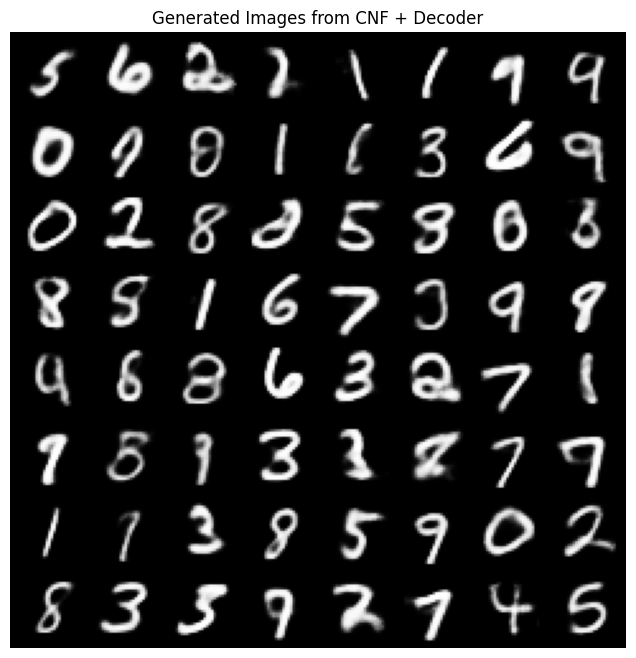

In [18]:
samples = sample_from_cnf_and_decode(cnf_model, decoder, n_samples=64)
show_images_CNF(samples)


In [ ]:
teacher = cnf_model
for round_idx in range(1):  
    print(f"\n===== Starting Reflow Round {round_idx + 1} =====")

    source_data = torch.randn(5000, 32).to(device)

    student = train_rf_student(teacher, source_data=source_data, epochs=100, batch_size=256, lr=1e-3, num_steps=20)

    samples = sample_from_rf_and_decode(student, decoder, n_samples=64)
    show_images_RF(samples, save_path=f"reflow_round_{round_idx+1}.png")

    teacher = student



===== Starting Reflow Round 1 =====
[RF] Epoch 0 | Loss: 0.0199
[RF] Epoch 10 | Loss: 0.0019
[RF] Epoch 20 | Loss: 0.0010
[RF] Epoch 30 | Loss: 0.0008


In [ ]:
import time
rf_model = teacher
def benchmark_inference_times(model_type, sample_sizes, num_trials=5):
    times = []
    for n_samples in sample_sizes:
        total_time = 0.0
        for _ in range(num_trials):
            z0 = torch.randn(n_samples, 32).to(device)

            start = time.time()
            if model_type == "cnf":
                _ = sample_from_cnf_and_decode(cnf_model, decoder, n_samples=n_samples)
            elif model_type == "rf":
                _ = sample_from_rf_and_decode(rf_model, decoder, n_samples=n_samples)
            total_time += time.time() - start

        avg_time = total_time / num_trials
        print(f"[{model_type.upper()}] Avg inference time over {num_trials} trials for {n_samples} samples: {avg_time:.4f}s")
        times.append(avg_time) 
    return times



In [ ]:
# sample_sizes = [10**i for i in range(1, 6)]  # [10, 100, 1000, 10000, 100000]
# cnf_times = benchmark_inference_times("cnf", sample_sizes, num_trials = 50)
# rf_times = benchmark_inference_times("rf", sample_sizes, num_trials = 50)



In [ ]:
# plt.figure(figsize=(10, 6))
# speedups = [c / r for c, r in zip(cnf_times, rf_times)]
# # Left Y-axis: Inference times
# ax1 = plt.gca()
# ln1 = ax1.plot(sample_sizes, cnf_times, label='CNF Time (s)', marker='o', color='tab:blue')
# ln2 = ax1.plot(sample_sizes, rf_times, label='RF Time (s)', marker='o', color='tab:orange')
# ax1.set_xlabel("Number of Samples (log scale)")
# ax1.set_ylabel("Inference Time (seconds)", color='tab:blue')
# ax1.set_xscale('log')
# ax1.set_yscale('log')
# ax1.set_xlim(min(sample_sizes), max(sample_sizes) * 1.5)
# ax1.tick_params(axis='y', labelcolor='tab:blue')

# # Right Y-axis: Speedup (CNF / RF)
# ax2 = ax1.twinx()
# ln3 = ax2.plot(sample_sizes, speedups, label='Speedup (CNF / RF)', marker='o', linestyle='--', color='tab:green')
# ax2.set_ylabel("Speedup", color='tab:green')
# ax2.tick_params(axis='y', labelcolor='tab:green')
# ax2.set_yscale('log')

# # Annotate points
# for x, y in zip(sample_sizes, cnf_times):
#     ax1.annotate(f"{y:.2e}", (x, y), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8)

# for x, y in zip(sample_sizes, rf_times):
#     ax1.annotate(f"{y:.2e}", (x, y), textcoords="offset points", xytext=(0, -10), ha='center', fontsize=8)

# for x, y in zip(sample_sizes, speedups):
#     ax2.annotate(f"{y:.1f}", (x, y), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8, color='green')

# # Legend
# lines = ln1 + ln2 + ln3
# labels = [l.get_label() for l in lines]
# ax1.legend(lines, labels, loc="upper left")

# plt.title("CNF vs RF Inference Time and Speedup (Dual Y-axis, Log Scale)")
# plt.grid(True, which="both", linestyle="--", alpha=0.3)
# plt.tight_layout()
# plt.show()

In [ ]:
# from torchvision.utils import save_image

# # Setup
# real_dir = "./data/real_mnist"
# os.makedirs(real_dir, exist_ok=True)
# real_loader = torch.utils.data.DataLoader(mnist_train, batch_size=1, shuffle=True)


# # Save only 100 real images
# num_images_to_save = 3000
# for i, (img, _) in tqdm(enumerate(real_loader), total=num_images_to_save, desc="Saving 3000 real MNIST images"):
#     save_image(img, os.path.join(real_dir, f"{i:05d}.png"))
#     if i >= num_images_to_save - 1:
#         break

In [ ]:
def generate_fake_images(model_type='rf', start_idx=0, count=100, latent_dim=32, save_dir="/mnt/data/fake_mnist_rf"):
    """
    Generate and save fake MNIST-style images using CNF or RF.

    Args:
        model_type (str): 'rf' or 'cnf'
        start_idx (int): starting index for saved image filenames
        count (int): number of images to generate
        latent_dim (int): dimension of latent vector
        save_dir (str): directory to save images
    """
    assert model_type in ['rf', 'cnf'], "model_type must be 'rf' or 'cnf'"
    os.makedirs(save_dir, exist_ok=True)

    model = rf_model if model_type == 'rf' else cnf_model
    model.eval()
    decoder.eval()

    num_steps = 20
    dt = 1.0 / num_steps

    with torch.no_grad():
        for i in range(count):
            z = torch.randn(1, latent_dim).to(device)

            if model_type == 'rf':
                t = torch.zeros(1, 1).to(device)
                for _ in range(num_steps):
                    v = model(t.squeeze(1), z)
                    z = z + dt * v
                    t += dt
                zt = z
            else:  # CNF
                from torchdiffeq import odeint
                t_span = torch.tensor([0.0, 1.0]).to(device)
                zt = odeint(model, z, t_span)[-1]

            x = decoder(zt)
            save_path = os.path.join(save_dir, f"{start_idx + i:05d}.png")
            save_image(x, save_path)

    print(f"Saved {count} fake images to {save_dir} using {model_type.upper()}")


In [ ]:
# # First batch of RF images
# generate_fake_images(model_type='rf', start_idx=0, count=3000, save_dir="./data/fake_mnist_rf")

# # First batch of CNF images
# generate_fake_images(model_type='cnf', start_idx=0, count=3000, save_dir="./data/fake_mnist_cnf")


In [ ]:
# import torch
# import torchvision
# import torchvision.transforms as transforms
# from pytorch_fid import fid_score

# # Prepare the real images and generated images
# real_images_folder = './data/real_mnist'
# generated_images_folder_cnf = './data/fake_mnist_cnf'
# generated_images_folder_rf = './data/fake_mnist_rf'

# # Load the pretrained model Inception-v3
# inception_model = torchvision.models.inception_v3(pretrained=True)




# # Calculate the FID score
# fid_value_cnf = fid_score.calculate_fid_given_paths(
#     paths=[real_images_folder, generated_images_folder_cnf],
#     batch_size=64,
#     device='cuda' if torch.cuda.is_available() else 'cpu',
#     dims=2048
# )


# fid_value_rf = fid_score.calculate_fid_given_paths(
#     paths=[real_images_folder, generated_images_folder_rf],
#     batch_size=64,
#     device='cuda' if torch.cuda.is_available() else 'cpu',
#     dims=2048
# )



In [ ]:
# print('FID value of CNF:', fid_value_cnf)
# print('FID value of RF:', fid_value_rf)

In [ ]:
def estimate_log_likelihood(cnf_model, z_T, atol=1e-4, rtol=1e-4):
    z_T = z_T.to(next(cnf_model.parameters()).device).requires_grad_(True)
    logp_T = torch.zeros(z_T.shape[0], device=z_T.device)

    def odefunc(t, state):
        z, logp = state
        dz = cnf_model(t, z)
        with torch.enable_grad():
            v = torch.randn_like(z)
            Jv = torch.autograd.grad(dz, z, v, create_graph=True)[0]
            trace = (Jv * v).sum(dim=1)
        return dz, -trace

    t_vals = torch.tensor([1.0, 0.0], device=z_T.device)
    z0, delta_logp = odeint(odefunc, (z_T, logp_T), t_vals, atol=atol, rtol=rtol)

    logp_0 = -0.5 * (z0[-1] ** 2 + np.log(2 * np.pi)).sum(dim=1)
    return logp_0 - delta_logp[-1]

def compare_density_and_time(cnf_model, rf_model, latent_dim=32, num_steps=20, batch_size=1000):
    device = next(cnf_model.parameters()).device
    z0_shared = torch.randn(batch_size, latent_dim).to(device)


    # -------------------------------
    # CNF 原生采样 + 评分
    # -------------------------------
    start_cnf = time.time()
    z0_cnf = z0_shared.clone()
    t_vals = torch.tensor([0.0, 1.0]).to(device)

    
    zT_cnf = odeint(cnf_model, z0_cnf, t_vals)[-1]
    logp_cnf = estimate_log_likelihood(cnf_model, zT_cnf)
    time_cnf = time.time() - start_cnf

    # -------------------------------
    # RF 采样 + CNF 评分
    # -------------------------------
    start_rf = time.time()
    z0_rf = z0_shared.clone()
    z_rf = z0_rf.clone()
    t_rf = torch.zeros(batch_size, 1).to(device)
    dt = 1.0 / num_steps

    
    for _ in range(num_steps):
        v = rf_model(t_rf, z_rf)
        z_rf = z_rf + dt * v
        t_rf += dt
    logp_rf = estimate_log_likelihood(cnf_model, z_rf)
    time_rf = time.time() - start_rf

    # -------------------------------
    # 输出对比结果
    # -------------------------------
    print(f"CNF: Avg logp = {logp_cnf.mean():.4f}, Time = {time_cnf:.2f}s")
    print(f"RF:  Avg logp = {logp_rf.mean():.4f}, Time = {time_rf:.2f}s")

    # -------------------------------
    # 可视化对比
    # -------------------------------
    plt.hist(logp_cnf.detach().cpu().numpy(), bins=50, alpha=0.5, label="CNF")
    plt.hist(logp_rf.detach().cpu().numpy(), bins=50, alpha=0.5, label="RF + CNF")
    plt.xlabel("Log-likelihood")
    plt.ylabel("Count")
    plt.title("Log-likelihood Distribution Comparison")
    plt.legend()
    plt.show()

In [ ]:
compare_density_and_time(cnf_model, rf_model, latent_dim=32, num_steps=20, batch_size=20)

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacty of 2.00 GiB of which 0 bytes is free. Of the allocated memory 16.96 GiB is allocated by PyTorch, and 41.98 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
print(torch.cuda.memory_allocated() / 1024**2, "MB allocated")
print(torch.cuda.memory_reserved() / 1024**2, "MB reserved")


17370.0244140625 MB allocated
17412.0 MB reserved
